Import 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression


from numpy.random import randint, randn, shuffle
from time import time
from scipy.stats import norm
from sklearn.utils import resample

Define Franke function

In [2]:
def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4

In [3]:
#sizes for plotting

figwidth = 10
figheigth = 10
fontsize = 18


Create design matrix for for two dimensions

In [4]:
def create_X(x, y, n):
    #n is the order of the polynomial
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    N = len(x)
    p = int((n+1)*(n+2)/2)  #Number of elements in beta, 
    X = np.ones((N, p))
    
    for i in range(1,n+1):
        q = int(i*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    
    return X

Define R2 score function

In [5]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Define Mean Squared Error (MSE) function

In [6]:
def MSE(y_data,y_model):
    return np.sum((y_data-y_model)**2)/np.size(y_model)

Generating Data

In [26]:
def generateData(n, degree, noise_factor):
    """
    n = size opf x and y
    degree = polynomial d
    noise_factor = self explanatory
    """
    np.random.seed(47309275)
    noise = noise_factor*np.random.randn(n)
    x = np.random.uniform(0,1,n)
    y = np.random.uniform(0,1,n)
    z = FrankeFunction(x,y) + noise
    X = create_X(x, y, degree)
    return z, X

Perform the Ordinary Least Square (OLS) method and print the MSE and R2 results

In [15]:
z, X = generateData(n=1000, degree=5, noise_factor=0.1)
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

z_tilde = X_train @ beta
z_predict = X_test @ beta

print("Training R2")
print(R2(z_train,z_tilde))
print(' ')
print("Training MSE")
print(MSE(z_train,z_tilde))
print(' ')
print("Test R2")
print(R2(z_test,z_predict))
print(' ')
print("Test MSE")
print(MSE(z_test,z_predict))

Training R2
0.895132323272409
 
Training MSE
0.010322516286512934
 
Test R2
0.8200272725838753
 
Test MSE
0.015620490147866293


Study the bias-variance trade-off by plotting the MSE for increasing model complexity (i.e. the number of polynomials)

Implement bootstrap resampling

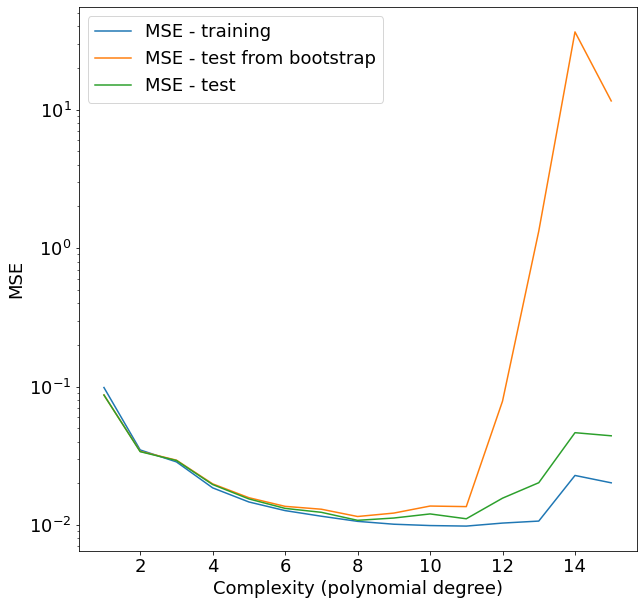

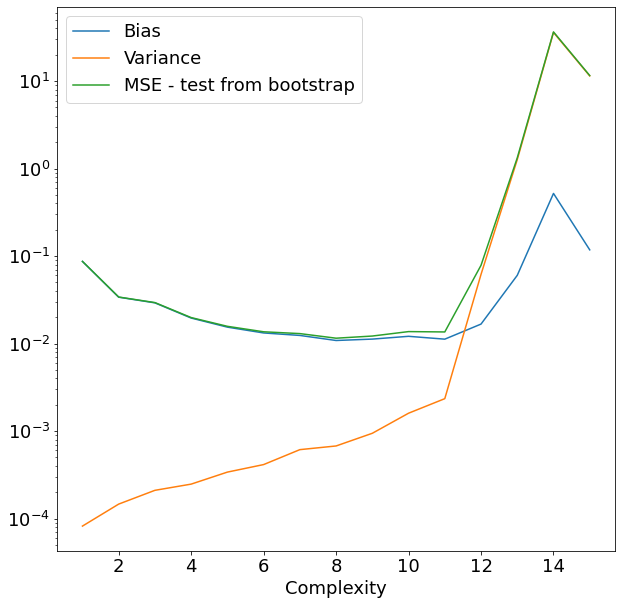

In [28]:
max_degree = 15
degree = np.linspace(1, max_degree, max_degree)
MSE_test = np.zeros(max_degree)
MSE_train = np.zeros(max_degree)
MSE_test_bootstrap = np.zeros(max_degree)

bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
error = np.zeros(max_degree)

for i in range(max_degree):
    z, X = generateData(n = 1000, degree = i, noise_factor = 0.1)
    
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

    scaler = StandardScaler(with_mean = True, with_std = False)
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Perform regular OLS
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta
    z_predict = X_test @ beta
    MSE_train[i] = MSE(z_train,z_tilde)
    MSE_test[i] = MSE(z_test,z_predict)
    
    #Perform OLS with bootstrap resampling
    MSE_test_bootstrap_values = np.zeros(n_bootstraps)
    z_predicted_bootstrap = np.empty((X_test.shape[0], n_bootstraps))
    
    n_bootstraps = 100
    for j in range(n_bootstraps):
        X_train_resample, z_train_resample = resample(X_train, z_train, replace=True)
        beta = np.linalg.inv(X_train_resample.T @ X_train_resample) @ X_train_resample.T @ z_train_resample
        z_predicted_bootstrap[:, j] = X_test @ beta
        MSE_test_bootstrap_values[j] = MSE(z_test, z_predicted_bootstrap[:, j]) 
    
    MSE_test_bootstrap[i] = np.mean(MSE_test_bootstrap_values)
    
    bias[i] = np.mean( (z_test - np.mean(z_predicted_bootstrap, axis=1))**2 )
    variance[i] = np.mean(np.var(z_predicted_bootstrap, axis=1))
    
plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('Complexity (polynomial degree)', fontsize=fontsize)
plt.plot(degree, MSE_train, label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap') 
plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.legend(fontsize=fontsize, loc='upper left')
plt.savefig('figures/mse_test_training_bootstrap')
plt.show()


plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.xlabel('Complexity', fontsize=fontsize)
plt.plot(degree, bias, label='Bias')
plt.plot(degree, variance, label='Variance')
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap')
plt.yscale('log')
plt.legend(fontsize=fontsize, loc='upper left')
plt.savefig('figures/bias_variande_tradeoff_bootstrap')
plt.show()

Implement k-fold cross validation

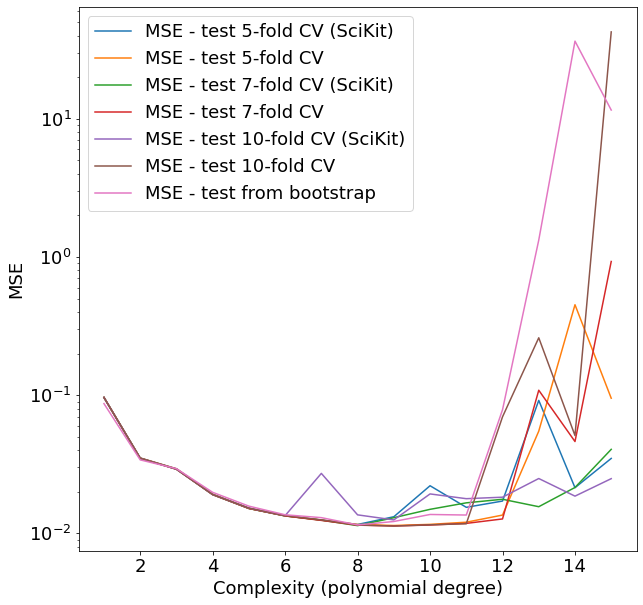

In [29]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) #not exactly sure why i need this...

max_degree = 15
folds = np.array([5,7,10], dtype=int) #number of folds

degree = np.linspace(1, max_degree, max_degree)

plt.figure(figsize=(figwidth, figheigth))

for k_folds in folds:
    
    MSE_test_kfold = np.zeros(max_degree)
    MSE_test_kfold_scikit = np.zeros(max_degree)
    
    for i in range(max_degree):
        
        z, X = generateData(n = 1000, degree = i, noise_factor = 0.1)
        
        #k-fold cross validation
        z_split = np.array_split(z, k_folds)
        X_split = np.array_split(X, k_folds)
        MSE_test_kfold_values = np.zeros(k_folds)

        for k in range(k_folds):
            
            z_test = z_split[k]
            z_train = np.concatenate(np.delete(z_split, k, 0))

            X_test = X_split[k] #picks out the kth matrix from X
            X_train = np.concatenate(np.delete(X_split, k, 0)) #deletes the kth matrix, and leaves the rest
            
            scaler = StandardScaler(with_mean = True, with_std = False)
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
            z_predict = X_test @ beta
            MSE_test_kfold_values[k] = MSE(z_test,z_predict)
            
        MSE_test_kfold[i] = np.mean(MSE_test_kfold_values)
        
        #k-fold cross validation using SciKit    
        kfold_scikit = KFold(n_splits = k_folds)
        MSE_test_kfold_values_scikit = np.zeros(k_folds)
        
        k=0
        for train_inds, test_inds in kfold_scikit.split(X):
            
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]
            
            scaler = StandardScaler(with_mean = True, with_std = False)
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model = LinearRegression(fit_intercept=True).fit(X_train, z_train)
            z_predict = model.predict(X_test)
            z_tilde = model.predict(X_train)
            MSE_test_kfold_values_scikit[k] = MSE(z_test,z_predict)
            k+=1
        
        MSE_test_kfold_scikit[i] = np.mean(MSE_test_kfold_values_scikit)

    plt.plot(degree, MSE_test_kfold_scikit, label='MSE - test %.i-fold CV (SciKit)'%k_folds)   
    plt.plot(degree, MSE_test_kfold, label='MSE - test %.i-fold CV'%k_folds)


plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('Complexity (polynomial degree)', fontsize=fontsize)
#plt.plot(degree, MSE_train, label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap')
#plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.savefig('figures/mse_test_training_bootstrap')
plt.show()

Implement Ridge Regression on Franke data with bootstrap resampling

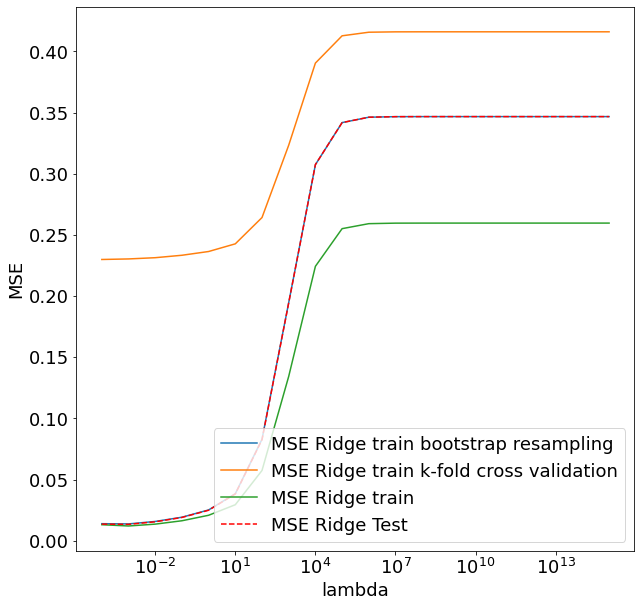

In [30]:
#perform ridge regression
p = 5 #polynomial degree
nlambdas = 20
lambdas = np.logspace(-4, 15, nlambdas)

z, X = generateData(n = 1000, degree = p, noise_factor = 0.1)
I = np.eye(X.shape[1])

#split data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

#scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

MSE_test = np.zeros(nlambdas)
MSE_train = np.zeros(nlambdas)
MSE_test_bootstrap = np.zeros(nlambdas)
MSE_test_kfold = np.zeros(nlambdas)

for i in range(nlambdas):
    _lambda = lambdas[i]
    beta = np.linalg.inv(X_train.T @ X_train + _lambda*I) @ X_train.T @ z_train #beta from Ridge-regression
    # and then make the prediction
    z_tilde = X_train @ beta
    z_predict = X_test @ beta
    MSE_train[i] = MSE(z_train, z_tilde)
    MSE_test[i] = MSE(z_test, z_predict)
    
    #Perform Ridge with bootstrap resampling
    MSE_test_bootstrap_values = np.zeros(n_bootstraps)
    z_predicted_bootstrap = np.empty((X_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        X_train_resample, z_train_resample = resample(X_train, z_train, replace=True)
        beta = np.linalg.inv(X_train_resample.T @ X_train_resample + _lambda*I) @ X_train_resample.T @ z_train_resample
        z_predicted_bootstrap[:, j] = X_test @ beta
        MSE_test_bootstrap_values[j] = MSE(z_test, z_predicted_bootstrap[:, j]) 
    
    MSE_test_bootstrap[i] = np.mean(MSE_test_bootstrap_values)
    
    k_folds=7
    for k in range(k_folds):
            
        z_test = z_split[k]
        z_train = np.concatenate(np.delete(z_split, k, 0))

        X_test = X_split[k] #picks out the kth matrix from X
        X_train = np.concatenate(np.delete(X_split, k, 0)) #deletes the kth matrix, and leaves the rest
        I = np.eye(X_train.shape[1])
        beta = np.linalg.inv(X_train.T @ X_train + _lambda*I) @ X_train.T @ z_train
        z_predict = X_test @ beta
            
        MSE_test_kfold_values[k] = MSE(z_test,z_predict)
            
    MSE_test_kfold[i] = np.mean(MSE_test_kfold_values)
    
    
    
plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.plot(lambdas, MSE_test_bootstrap, label = 'MSE Ridge train bootstrap resampling')
plt.plot(lambdas, MSE_test_kfold, label = 'MSE Ridge train k-fold cross validation')
plt.plot(lambdas, MSE_train, label = 'MSE Ridge train')
plt.plot(lambdas, MSE_test, 'r--', label = 'MSE Ridge Test')
plt.xscale('log')
plt.xlabel('lambda', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='lower right')
plt.show()


Implement Lasso regression on Franke data

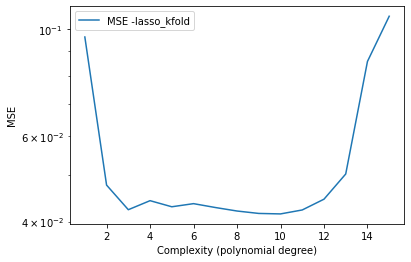

In [12]:
np.random.seed(47309275)
max_degree = 15
n = 1000
noise_factor = .1
n_bootstraps = 100

degree = np.linspace(1, max_degree, max_degree)
MSE_test = np.zeros(max_degree)
MSE_train = np.zeros(max_degree)
MSE_test_bootstrap = np.zeros(max_degree)

bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
error = np.zeros(max_degree)

noise = noise_factor*np.random.randn(n)
x = np.random.uniform(0,1,n)
y = np.random.uniform(0,1,n)

z = FrankeFunction(x,y) + noise

#model_lasso = skl.Lasso(alpha=_lambda, fit_intercept=False).fit(X, z)


def Lasso(x, y, z, n_lambda, max_degree, method):

    
    bias = np.zeros(max_degree)
    variance = np.zeros(max_degree)
    error = np.zeros(max_degree)
    
    _lambda = np.logspace(-8, -1, n_lambda)
    #_lambda = [0.1]
    
    
    if (method == 'Bootstrap'):
        n_bootstraps = 100
        MSE_test_bootstrap = np.zeros(max_degree)
        
        
        clf_lasso = skl.Lasso(alpha=_lambda, fit_intercept=False).fit(X, z)
        
    if (method == 'k-fold_CV'):
        k_folds = 10 #number of folds


        MSE_lasso_kfold = np.zeros(max_degree)


        for i in range(max_degree):
            X = create_X(x, y, i)
            z_split = np.array_split(z, k_folds)
            X_split = np.array_split(X, k_folds)
            MSE_test_kfold_values = np.zeros(k_folds)
    
            for k in range(k_folds):
                z_test = z_split[k]
                z_train = np.concatenate(np.delete(z_split, k, 0))
        
                X_test = X_split[k] #picks out the kth matrix from X
                X_train = np.concatenate(np.delete(X_split, k, 0)) #deletes the kth matrix, and leaves the rest
        
                clf_lasso = skl.Lasso(alpha=_lambda[i], fit_intercept=False, normalize=True, tol=0.1).fit(X_train, z_train)
                beta_lasso_kfold = clf_lasso.coef_
            
                z_tilde = X_train @ beta_lasso_kfold
                z_predict = X_test @ beta_lasso_kfold
                MSE_test_kfold_values[k] = MSE(z_test,z_predict)
    
            MSE_lasso_kfold[i] = np.mean(MSE_test_kfold_values)
        
        return MSE_lasso_kfold

    
plt.figure()
plt.ylabel('MSE')
plt.xlabel('Complexity (polynomial degree)')
plt.plot(degree, Lasso(x,y,z,n_lambda=max_degree,max_degree=max_degree,method='k-fold_CV'), label='MSE -lasso_kfold') 
plt.yscale('log')
plt.legend()
plt.show()
        


Prepare real data for analysis

Apply all three regression methods to the real data with cross-validation as resampling